<a href="https://colab.research.google.com/github/baoloc97/Data-science/blob/main/Ban_Detect_TXT_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import**

In [ ]:
!python --version

Python 3.7.10


In [ ]:
!pip install tensorflow_hub -q
!pip install keras tf-models-official pydot graphviz -q

     |████████████████████████████████| 1.6MB 4.3MB/s 
     |████████████████████████████████| 1.2MB 37.8MB/s 
     |████████████████████████████████| 215kB 35.7MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 
     |████████████████████████████████| 102kB 11.0MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 686kB 34.6MB/s 
     |████████████████████████████████| 358kB 37.7MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
ERROR: tf-models-official 2.5.0 has requirement pyyaml>=5.1, but you'll have pyyaml 3.13 which is incompatible.


In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

# from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# **Read data**

In [ ]:
df = pd.read_excel('ban_norm.xlsx')
df.head()

Unnamed: 0  is_banned                                       product_name
0           0          1  1pc Fishing Two Finger Gloves Non-Slip Thumb I...
1           1          1  attwood 5530-36A7 All-Round 36-Inch Marine Boa...
2           2          1  HUK Men's Kryptek Strike Long Sleeve Performan...
3           3          0  Electric Nail Drill,Professional Nail Drill Ki...
4           4          1  Mạle Vịbṙating Pṙọstate Mạssageṙ Ạnal Sẹx Toys...

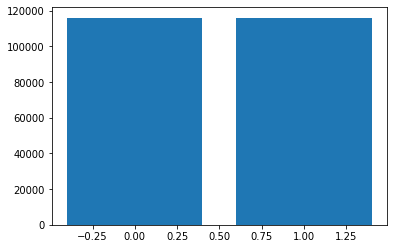

In [ ]:
classes = df.is_banned.unique()
counts = []

for i in classes:
  count = len(df[df.is_banned==i])
  counts.append(count)

plt.bar(classes, counts)
plt.show()

# **Train Test Split**

In [ ]:
sample_size = int(len(df)*0.2)
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.product_name.values
y = sampleDf.is_banned.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [ ]:
print('Length of y_train: {}, y_test: {}'.format(len(y_train),len(y_test)))
print('0: {}, 1: {}'.format(y_train.tolist().count(0),y_train.tolist().count(1)))

Length of y_train: 37162, y_test: 9291
0: 18533, 1: 18629


# **Label Encoding (Not necessary)**

In [29]:
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

# **Tokenization**

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
do_lower_case

False

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized shape', tweets.shape.as_list())

Tokenized shape [37162, None]


In [ ]:
tweets[0]

<tf.Tensor: shape=(24,), dtype=int32, numpy=
array([   151,  11396,  79573,    152,  11090,  10729, 103477,    191,
          120,  74351,  29207,  10117,    160,  12985,  67882,  10162,
        20220,  55533,  10165,    117,  80484,  36448,  10806,    102],
      dtype=int32)>

In [ ]:
x_train[0]

'N8 Tactical OT2 Compact w/Laser Inside The Waistband Holster, Multiple Fits'

In [ ]:
# tokenizedTweet = tokenizer.tokenize(x_train[0])
# for i in tokenizedTweet:
#   print(i, tokenizer.convert_tokens_to_ids([i]))

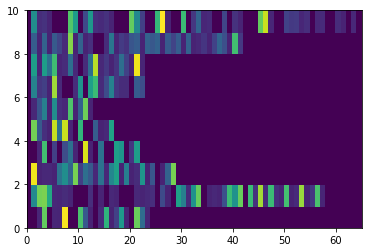

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

# **Mask & Input Type**

In [ ]:
input_word_ids

<tf.RaggedTensor [[101, 151, 11396, 79573, 152, 11090, 10729, 103477, 191, 120, 74351, 29207, 10117, 160, 12985, 67882, 10162, 20220, 55533, 10165, 117, 80484, 36448, 10806, 102], [101, 49307, 82272, 83529, 62997, 11537, 11166, 12674, 10884, 117, 124, 118, 13533, 117, 10208, 118, 11500, 10410, 113, 126, 118, 11500, 10410, 11982, 13533, 114, 23651, 10157, 118, 59640, 44950, 12425, 53453, 80365, 117, 10186, 11779, 10576, 25690, 71404, 53453, 80365, 117, 71404, 14883, 89891, 12689, 71404, 13810, 10604, 73285, 10129, 12613, 88455, 10112, 16680, 74599, 10822, 102], [101, 102204, 10161, 11779, 11481, 10174, 39615, 51266, 32792, 83232, 19425, 37592, 29342, 11704, 39910, 11704, 47828, 59533, 10169, 44572, 10111, 12762, 54546, 10142, 28151, 117, 10169, 32930, 83237, 102], [101, 147, 11403, 72759, 118, 19762, 118, 23859, 38244, 10368, 113, 98747, 10112, 118, 39264, 114, 129, 58768, 54434, 120, 16017, 58240, 102], [101, 82376, 29389, 13998, 10129, 95431, 38109, 95703, 10822, 144, 68228, 117, 155,

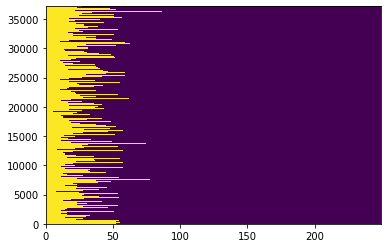

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

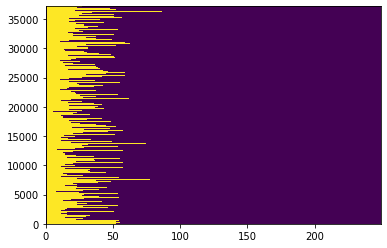

In [ ]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
input_type_ids

<tf.Tensor: shape=(37162, 249), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

# **Remake into Function**

In [ ]:
lens = [len(i) for i in input_word_ids]

In [ ]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

In [ ]:
import seaborn as sns

sns.distplot(lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
max_seq_length = 100

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

# **Train**

In [30]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.3)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

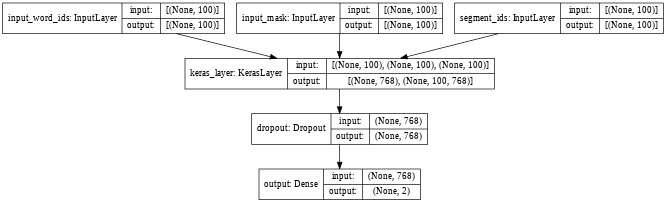

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [32]:
epochs = 5
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-6, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [33]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [35]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/5
2323/2323 [==============================] - 1836s 782ms/step - loss: 0.4913 - accuracy: 0.7473 - val_loss: 0.2775 - val_accuracy: 0.8860
Epoch 2/5
2323/2323 [==============================] - 1814s 781ms/step - loss: 0.2718 - accuracy: 0.8900 - val_loss: 0.2324 - val_accuracy: 0.9088
Epoch 3/5
2323/2323 [==============================] - 1813s 780ms/step - loss: 0.2244 - accuracy: 0.9129 - val_loss: 0.2261 - val_accuracy: 0.9152
Epoch 4/5
2323/2323 [==============================] - 1808s 778ms/step - loss: 0.2017 - accuracy: 0.9238 - val_loss: 0.2238 - val_accuracy: 0.9197
Epoch 5/5
2323/2323 [==============================] - 1812s 780ms/step - loss: 0.1841 - accuracy: 0.9336 - val_loss: 0.2268 - val_accuracy: 0.9247


In [36]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9498
Testing Accuracy:  0.9247


In [37]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

146/146 [==============================] - 113s 777ms/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4705
           1       0.93      0.92      0.92      4586

    accuracy                           0.92      9291
   macro avg       0.92      0.92      0.92      9291
weighted avg       0.92      0.92      0.92      9291



In [38]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

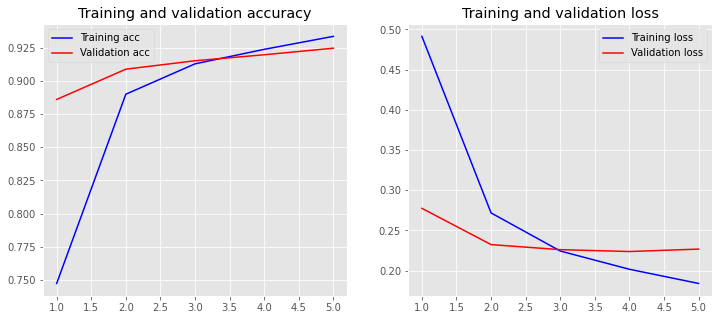

In [39]:
plot_history(history)

# **Save**

In [40]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
model_fname = 'BanUS_detect_v2'
my_wd = '/content/'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/BanUS_detect_v2/assets


INFO:tensorflow:Assets written to: /content/BanUS_detect_v2/assets


In [43]:
from google.colab import files
files.download('BanUS_detect_v2') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.9247


In [44]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [45]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
# tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
# for i in tokenizedTweet:
#   print(i, tokenizerSaved.convert_tokens_to_ids([i]))

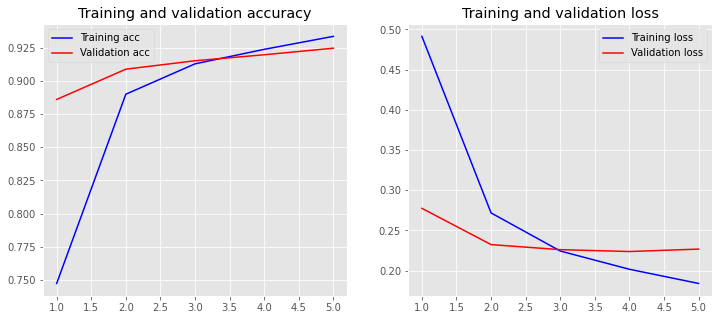

In [46]:
plot_history(history)

[1 0]


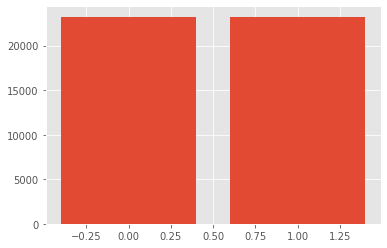

In [47]:
classes = sampleDf.is_banned.unique()
print(classes)
counts = []

for i in classes:
  count = len(sampleDf[sampleDf.is_banned==i])
  counts.append(count)

plt.bar(classes, counts)
plt.show()

In [59]:
f = open('text_ban_1000.txt','r')
count =0
sum = 0
while(True):
  line = f.readline()
  if not line:
    break
  tweet = [line]

  inputs = bert_encode(string_list=list(tweet), 
                      tokenizer=tokenizerSaved, 
                      max_seq_length=100)
  prediction = new_model.predict(inputs)
  #print(prediction)
  if encoder.classes_[np.argmax(prediction)]!=4:
    count = count+1
    sum+=1
  else:
    sum+=1  
  #print('Product is', 'normal' if encoder.classes_[np.argmax(prediction)]==4 else 'banned')
print('Accuracy for predict : ', float(count/sum)*100,'%')  
  











Accuracy for predict :  100.0 %


In [49]:
prediction = new_model.predict(inputs)
print(prediction)
print('Product is', 'normal' if encoder.classes_[np.argmax(prediction)]==4 else 'banned')

[[0.9972772  0.00272277]]
Product is banned


In [ ]:
inputs